# Analysis of NBA Scoring on Christmas Day from 1979 to 2020

By Henry Pizzo

## Introduction

In this project, I will step through the data science pipeline with the goal of analyzing scoring in NBA games on Christmas Day since 1979.
The NBA has been playing games on Christmas Day since 1947. 
I have always been curious about how athletes feel playing games on certain major holidays, such as Christmas (NBA), or Thanksgiving (NFL). I wonder how a team's mindset is affected by feeling that their work is keeping them from friends and family on a holiday. 
Perhaps scoring reflects a team's state of mind. Perhaps a team will slump because of the dissapointment of not being with family and friends on a holliday. Perhaps the home team has a major advantage as they can at least be in the same city as their families.
Furthermore, there is a general assumption that teams are scoring more points now than ever before in the NBA, with the meteoric rise in popularity of the three point shot (https://www.usatoday.com/story/sports/nba/2018/10/25/nba-scoring-increase-points-up-2018-19-season/1765493002/). We will also explore the trends in scoring over the years 1979 to 2020

# Part 1: Data Collection

## Importing Libraries

Here we will import the libraries that we need to accomplish our tasks. Libraries like requests, json, and BeautifulSoup are used to collect data and put it into a pandas dataframe. We will also import libraries used for plotting and Machine Learning analysis.

In [46]:
import requests
import json
import numpy as np
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.linear_model import LinearRegression

## Data Scraping

We will be getting information from the website https://www.balldontlie.io/ which is an API containing data on the NBA. This API makes it very easy for us to gather data, all we have to do is navigate the website to find the data that we want and use the link provided. Here is an example using requests to get a table of all of the teams in the NBA:

In [47]:
#use requests to get information from the website
response = requests.get('https://www.balldontlie.io/api/v1/teams')

#BeautifulSoup makes the content look nice so we can look through it for relevant information
#or some insight into the structure of the data
root = BeautifulSoup(response.content)

#we can see from the structure of "root" that the API gave us a JSON object. The API is also
#very good at reminding us that the commands return JSON objects. Herewe attempt to transfer 
#the JSON into a pandas dataframe using json.loads(), and finally pd.json_normalize to 
#fix the columns
data = json.loads(response.text)
teams_df = pd.json_normalize(data, 'data')
teams_df.head()

,id,abbreviation,city,conference,division,full_name,name
0,1,ATL,Atlanta,East,Southeast,Atlanta Hawks,Hawks
1,2,BOS,Boston,East,Atlantic,Boston Celtics,Celtics
2,3,BKN,Brooklyn,East,Atlantic,Brooklyn Nets,Nets
3,4,CHA,Charlotte,East,Southeast,Charlotte Hornets,Hornets
4,5,CHI,Chicago,East,Central,Chicago Bulls,Bulls


Now that we are confident in our data gathering techniques and have explored the API, we can work on gathering information more relevant to our mission. Here we will take scoring stats from all games played on Christmas Day (December 25th) since 1979, using a "dates" query parameter specified by the API.

In [48]:
#data from balldontlie for games on Christmas day since 1979

#start by getting data from 1979 to create a table that we can then append to
url = 'https://www.balldontlie.io/api/v1/games?per_page=100&dates[]=1979-12-25'
response = requests.get(url)
root = BeautifulSoup(response.content)
data = json.loads(response.text)
table = pd.json_normalize(data, 'data')

#loop through subsequent years, appending data to the table each time
for year in range(1980, 2021):
    
    #adding the target year into our query string
    string ='https://www.balldontlie.io/api/v1/games?per_page=100&dates[]='+str(year)+'-12-25'
    
    #carry on with the rest of the data collection
    response = requests.get(string)
    root = BeautifulSoup(response.content)
    data = json.loads(response.text)
    
    #append the table for target year to the table of previous years
    table = table.append(pd.json_normalize(data, 'data'), ignore_index=True)
table

,id,date,home_team_score,period,postseason,season,status,time,visitor_team_score,home_team.id,...,home_team.division,home_team.full_name,home_team.name,visitor_team.id,visitor_team.abbreviation,visitor_team.city,visitor_team.conference,visitor_team.division,visitor_team.full_name,visitor_team.name
0,35901,1979-12-25T00:00:00.000Z,131,4,False,1979,Final,,102,20,...,Atlantic,New York Knicks,Knicks,3,BKN,Brooklyn,East,Atlantic,Brooklyn Nets,Nets
1,35951,1979-12-25T00:00:00.000Z,111,4,False,1979,Final,,101,6,...,Central,Cleveland Cavaliers,Cavaliers,9,DET,Detroit,East,Central,Detroit Pistons,Pistons
2,35985,1979-12-25T00:00:00.000Z,122,4,False,1979,Final,,111,29,...,Northwest,Utah Jazz,Jazz,8,DEN,Denver,West,Northwest,Denver Nuggets,Nuggets
3,35986,1979-12-25T00:00:00.000Z,113,4,False,1979,Final,,91,25,...,Northwest,Portland Trail Blazers,Trail Blazers,10,GSW,Golden State,West,Pacific,Golden State Warriors,Warriors
4,35987,1979-12-25T00:00:00.000Z,92,4,False,1979,Final,,95,30,...,Southeast,Washington Wizards,Wizards,23,PHI,Philadelphia,East,Atlantic,Philadelphia 76ers,76ers
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,127517,2020-12-25T00:00:00.000Z,95,4,False,2020,Final,,123,2,...,Atlantic,Boston Celtics,Celtics,3,BKN,Brooklyn,East,Atlantic,Brooklyn Nets,Nets
128,127518,2020-12-25T00:00:00.000Z,108,4,False,2020,Final,,121,8,...,Northwest,Denver Nuggets,Nuggets,13,LAC,LA,West,Pacific,LA Clippers,Clippers
129,127519,2020-12-25T00:00:00.000Z,111,4,False,2020,Final,,98,16,...,Southeast,Miami Heat,Heat,19,NOP,New Orleans,West,Southwest,New Orleans Pelicans,Pelicans
130,127520,2020-12-25T00:00:00.000Z,138,4,False,2020,Final,,115,14,...,Pacific,Los Angeles Lakers,Lakers,7,DAL,Dallas,West,Southwest,Dallas Mavericks,Mavericks


# Part 2: Data Management / Representation

Data Management, sometimes called Data Tidying, is all about making the information we have from the source into "nicer", more workable data. As we can see from the table above, there are so many columns that we can't even see all of them. We can access the columns field of our table to see the names of all of the columns: 

In [49]:
table.columns

Index(['id', 'date', 'home_team_score', 'period', 'postseason', 'season',
       'status', 'time', 'visitor_team_score', 'home_team.id',
       'home_team.abbreviation', 'home_team.city', 'home_team.conference',
       'home_team.division', 'home_team.full_name', 'home_team.name',
       'visitor_team.id', 'visitor_team.abbreviation', 'visitor_team.city',
       'visitor_team.conference', 'visitor_team.division',
       'visitor_team.full_name', 'visitor_team.name'],
      dtype='object')

We can see above that there are a lot of columns, and many of them are redundant and useless. For example, we don't need so many columns of team identifiers. It might be easier to look through and choose the columns we want to KEEP, rather than looking for columns to get rid of. The most relevant info to our cause would be the date, home and visiting team scores, and perhaps the team names. We will also keep two other columns (renamed dummy1 and dummy2) so that we do not have to create new ones later on, we can simply change these:

In [50]:
#keep relevant info, change 'visitor' to 'away'
table = table[['date', 'season', 'home_team.name', 'home_team_score', 
                     'visitor_team.name', 'visitor_team_score', 
               
               #below are placeholder cols for averages
               'home_team.abbreviation', 'visitor_team.abbreviation']]

table.columns = ['date', 'season', 'home_team.name', 'home_team_score', 
                     'away_team.name', 'away_team_score', 
                  
                  #rename placeholder cols
                  'dummy1', 'dummy2']
table.head()

,date,season,home_team.name,home_team_score,away_team.name,away_team_score,dummy1,dummy2
0,1979-12-25T00:00:00.000Z,1979,Knicks,131,Nets,102,NYK,BKN
1,1979-12-25T00:00:00.000Z,1979,Cavaliers,111,Pistons,101,CLE,DET
2,1979-12-25T00:00:00.000Z,1979,Jazz,122,Nuggets,111,UTA,DEN
3,1979-12-25T00:00:00.000Z,1979,Trail Blazers,113,Warriors,91,POR,GSW
4,1979-12-25T00:00:00.000Z,1979,Wizards,92,76ers,95,WAS,PHI


We want the average scoring for each year, which we can add into the placeholder column:

In [51]:
#get average score per season for home and away teams
avg_home_score = []
avg_away_score = []

#loop through seasons
for season in range(1979, 2021):
    
    #keep only games in target season
    temp_table = table[table['season'] == season]
    
    #add the sum of all of the home team scores divided by the number of games to the array
    avg_home_score.append(temp_table['home_team_score'].sum() / 
                          (1 if len(temp_table.index) == 0 else len(temp_table.index)))
    
    #add the sum of all of the away team scores divided by the number of games to the array
    avg_away_score.append(temp_table['away_team_score'].sum() / 
                          (1 if len(temp_table.index) == 0 else len(temp_table.index)))
    
#add cols for average scores per season
for index, row in table.iterrows():
    table.at[index,'dummy1'] = avg_home_score[row['season']-1979]
    table.at[index,'dummy2'] = avg_away_score[row['season']-1979]

table.columns = ['date', 'season', 'home_team.name', 'home_team_score', 
                     'away_team.name', 'away_team_score', 
                  
                  #rename placeholder cols
                  'avg_home_score', 'avg_away_score']
table.head()

,date,season,home_team.name,home_team_score,away_team.name,away_team_score,avg_home_score,avg_away_score
0,1979-12-25T00:00:00.000Z,1979,Knicks,131,Nets,102,113.8,100
1,1979-12-25T00:00:00.000Z,1979,Cavaliers,111,Pistons,101,113.8,100
2,1979-12-25T00:00:00.000Z,1979,Jazz,122,Nuggets,111,113.8,100
3,1979-12-25T00:00:00.000Z,1979,Trail Blazers,113,Warriors,91,113.8,100
4,1979-12-25T00:00:00.000Z,1979,Wizards,92,76ers,95,113.8,100


# Part 3: Data Visualization and Analysis

Now that we have collected our data and it is tidy and ready to use, we can start with some simple data visualization to get an idea of what we are looking at and possibly to form hypotheses. Let's start with a simple scatter plot of home team score versus season, and away team score versus season:

Text(0.5, 1.0, 'home team scores 1979-2020')

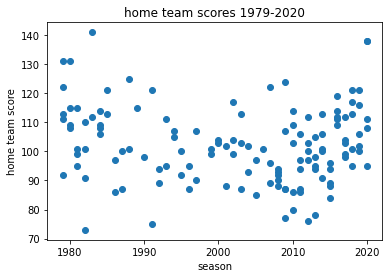

In [52]:
plt.scatter(table['season'], table['home_team_score'])
plt.xlabel("season")
plt.ylabel("home team score")
plt.title("home team scores 1979-2020")

Text(0.5, 1.0, 'away team scores 1979-2020')

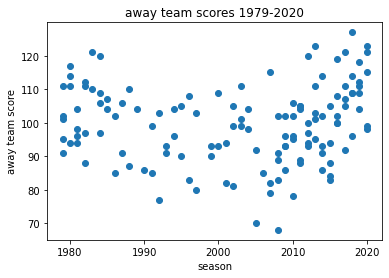

In [53]:
plt.scatter(table['season'], table['away_team_score'])
plt.xlabel("season")
plt.ylabel("away team score")
plt.title("away team scores 1979-2020")

Now that we can see the general shape of the data for each home and away scoring, let's plot them next to eachother in a bar plot to start to get an idea of their relationship to one another:

Text(0.5, 1.0, 'home (blue) and away (orange) team scores vs season')

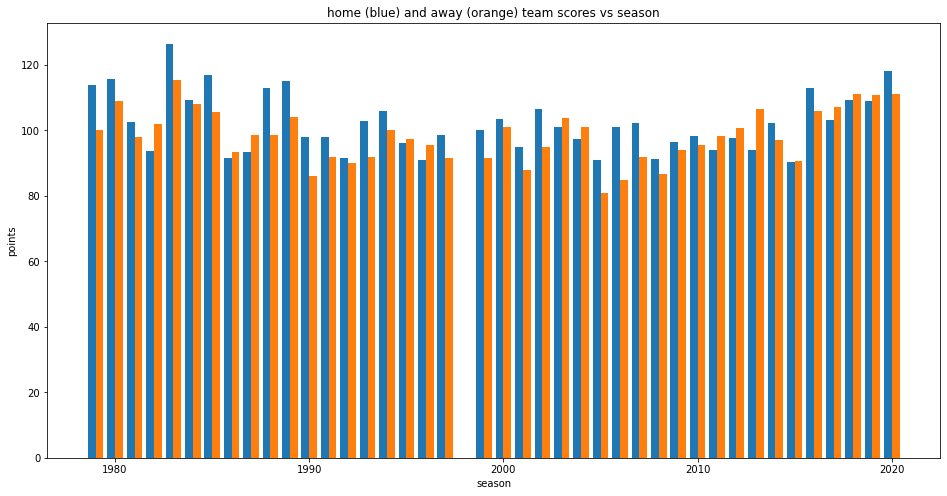

In [54]:
plt.figure(figsize=(16, 8))
plot = plt.subplot(111)
plot.bar(table['season']-0.2, table['avg_home_score'],width=0.4)
plot.bar(table['season']+0.2, table['avg_away_score'], width=0.4)
plt.xlabel("season")
plt.ylabel("points")
plt.title("home (blue) and away (orange) team scores vs season")

Above we can see the home and away scores plotted right next to eachother. Although this is a great view of the data, it doesn't seem to really tell us anything. Maybe we can get a better insight by plotting the away team score versus the home team score. Let's try it:

Text(0.5, 1.0, 'games on Christmas Day 1979-2020')

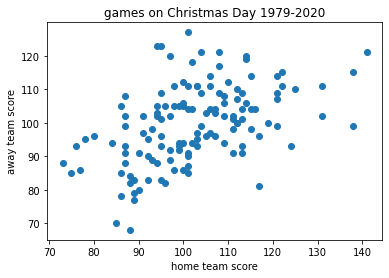

In [55]:
plt.scatter(table['home_team_score'], table['away_team_score'])
plt.xlabel("home team score")
plt.ylabel("away team score")
plt.title("games on Christmas Day 1979-2020")

For the graph above, each datapoint represents a game, the x value represents the home team score and the y value represents the away team score. That looks interesting, and definetly looks more like a pattern. Maybe we can use averages to clean up the graph and get an even better look at the relationship:

Text(0.5, 1.0, 'averages scores for games on Christmas Day 1979-2020')

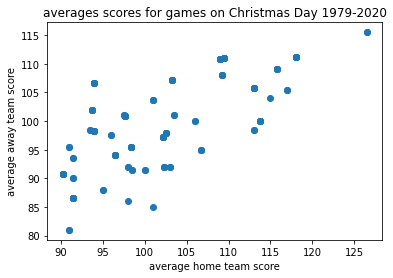

In [56]:
plt.scatter(table['avg_home_score'], table['avg_away_score'])
plt.xlabel("average home team score")
plt.ylabel("average away team score")
plt.title("averages scores for games on Christmas Day 1979-2020")

Here we can start to see a relationship between average home score and average away score. 

# Part 4: Hypothesis Testing / Machine Learning

Now we will test some hypotheses, possibly using machine learning. Our original hypotheses were that the home team has an advantage over the away team, and that scoring has increased since 1979.

## Home team advantage?

The first hypothesis that we can test is wether or not the home team has an advantage over the away team. For this, we can plot the difference in the home and away scores. If the home team has an advantage, we should see that (home score) - (away score) are mostly positive values with some possible outliers. Let's see:

Text(0.5, 1.0, 'home score - away score vs season')

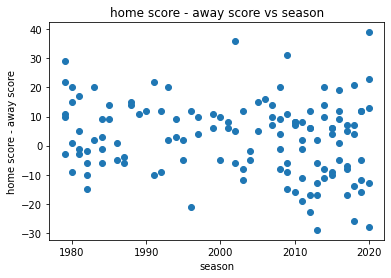

In [57]:
plt.scatter(table['season'], table['home_team_score'] - table['away_team_score'])
plt.xlabel("season")
plt.ylabel("home score - away score")
plt.title("home score - away score vs season")

Already we can see that there are a lot of negative values, hinting that we might be wrong. Let's try to get a cleaner view using the averages per season:

Text(0.5, 1.0, 'avg home score - avg away score vs season')

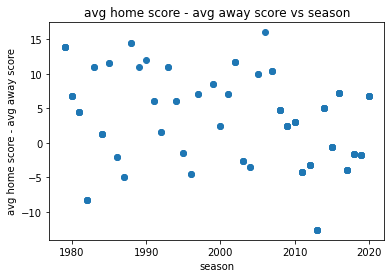

In [58]:
plt.scatter(table['season'], table['avg_home_score'] - table['avg_away_score'])
plt.xlabel("season")
plt.ylabel("avg home score - avg away score")
plt.title("avg home score - avg away score vs season")

That definitely clears things up a bit, but it is still a little bit all over the place. For this hypothesis, we don't really care about the season, so we can make a violin plot to show the distribution of points relative to eachother. The thicker the violin, the more datapoints that were in that range:

Text(0.5, 1.0, 'Distribution of differences in score over all seasons')

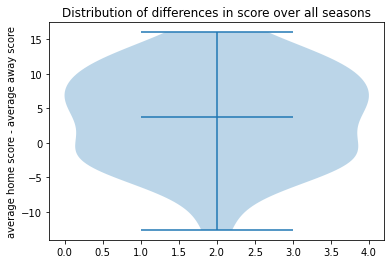

In [59]:
#gathering differences into an array to plot in the same 'violin'
avg_differences = []
for i in range(len(avg_away_score)):
    avg_differences.append(avg_home_score[i] - avg_away_score[i])

#plotting in a violin plot 
plt.violinplot(avg_differences,[2],widths=4,showmeans=True)
plt.xlabel("")
plt.ylabel("average home score - average away score")
plt.title("Distribution of differences in score over all seasons")

Now we can see that the home team does outscore the away team, on average, most of the time, but it is definitely less overwhelming than I would have thought, with there still being some prominant negative values. However, there are more positive values and the positive values are larger. We can see that the violin becomes thickest at around (home score) - (away score) = 7, and then again at (home score) - (away score) = -1. Furthermore, the average line in the middle of the violin is at around +4, giving even more evidence that the home team does tend to outscore the away team.

## Has scoring increased since 1979?

### Linear Regression

Now we can test the hypothesis that scoring in the NBA has increased over the years, as analyzed by scoring on the same day (12/25) for the past 40 years. Let's map our home team scoring on Christmas Day since 1979 and add a linear regression to hopefuly see a trend:

Text(0.5, 1.0, 'home team score vs season with liner regression')

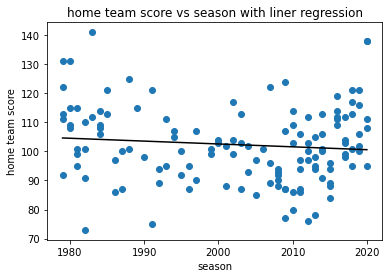

In [60]:
#fit a linear model to home team score vs season
x = table['season'].values.reshape(-1,1)
y = table['home_team_score'].values.reshape(-1,1)
model = linear_model.LinearRegression().fit(x, y)
predictions = model.predict(x)
plt.scatter(table['season'], table['home_team_score'])
plt.plot(table['season'], predictions, c='black')
plt.xlabel("season")
plt.ylabel("home team score")
plt.title("home team score vs season with liner regression")

Wow, here is something we were definitely not expecting to see: according to our regression line, scoring has actually DECREASED since 1979! Let's again get a less clustered view by using the averages:

Text(0.5, 1.0, 'avg home team score vs season with liner regression')

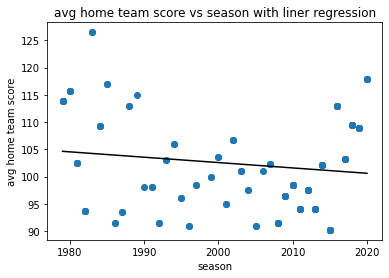

In [61]:
X = table['season'].values.reshape(-1,1)
y = table['avg_home_score'].values.reshape(-1,1)
model = linear_model.LinearRegression().fit(X, y)
predictions = model.predict(X)
plt.scatter(table['season'], table['avg_home_score'])
plt.plot(table['season'], predictions, c='black')
plt.xlabel("season")
plt.ylabel("avg home team score")
plt.title("avg home team score vs season with liner regression")

In this view it is clear that while fitting average home team score vs season with a linear regression, we get a line with a negative slope, signifying that scoring is decreasing. One thing that you might notice, however, is that there are not a lot of datapoints that are on, or even very close to, the regression line. This should tell us that maybe a linear regression is noth the best way to fit this data. Let's take a look at our residuals, that is (avg home score) - (predicted score):

<ipython-input-62-6bb5d60936eb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table['predictions'] = pd.Series(predictions.flatten())
<ipython-input-62-6bb5d60936eb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table['residuals'] = table['avg_home_score'] - table['predictions']


Text(0.5, 1.0, 'average home score residuals')

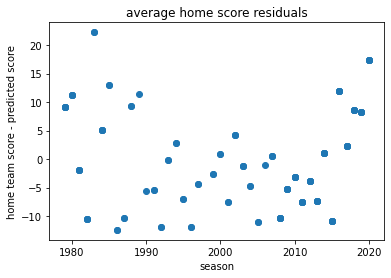

In [62]:
table['predictions'] = pd.Series(predictions.flatten())
table['residuals'] = table['avg_home_score'] - table['predictions']
plt.scatter(table['season'], table['residuals'])
plt.xlabel("season")
plt.ylabel("home team score - predicted score")
plt.title("average home score residuals")

We can see here that our residuals are very varied. Let's try fitting a polynomial regression:

## Polynomial Regression

For more information: https://towardsdatascience.com/machine-learning-polynomial-regression-with-python-5328e4e8a386

Instead of fitting our data with a straight line, we can fit our data with a polynomial. This will hopefully allow us to better respresent our data.

Text(0.5, 1.0, 'quadratic regression avg home score vs season')

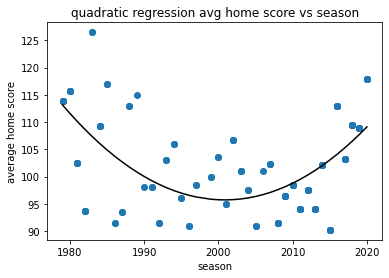

In [63]:
from sklearn.preprocessing import PolynomialFeatures
#here we can shoose the degree of our polynomial. Degree=2 means a quadratic
poly_reg = PolynomialFeatures(degree=2)
X_poly = poly_reg.fit_transform(X)
pol_reg = LinearRegression()
pol_reg.fit(X_poly, y)
plt.scatter(X, y)
plt.plot(X, pol_reg.predict(poly_reg.fit_transform(X)), color='black')
plt.xlabel("season")
plt.ylabel("average home score")
plt.title("quadratic regression avg home score vs season")

It is clear to see that this line fits the data set better than a linear regression. It also reveals an upwards trend in scoring in the past 10 or 20 years. Let's raise the degree of our polynomial once more to see if any other relationships become obvious:

Text(0.5, 1.0, 'cubic regression avg home score vs season')

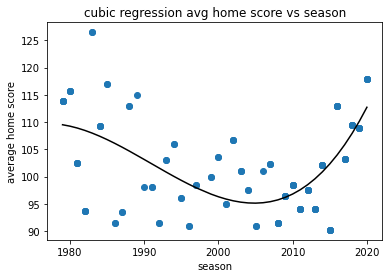

In [64]:
#degree=3 is a cubic polynomial
X = table['season'].values.reshape(-1,1)
y = table['avg_home_score'].values.reshape(-1,1)
poly_reg = PolynomialFeatures(degree=3)
X_poly = poly_reg.fit_transform(X)
pol_reg = LinearRegression()
pol_reg.fit(X_poly, y)
plt.scatter(X, y)
plt.plot(X, pol_reg.predict(poly_reg.fit_transform(X)), color='black')
plt.xlabel("season")
plt.ylabel("average home score")
plt.title("cubic regression avg home score vs season")

Here we can see that our model has predicted that scoring in 2020 is actually greater than in 1979! This is remarkable. It also reveals a sharp increase in scoring starting in the past 10 years and sharply rising in the last 5 years. Let's plot the average away scores as well, just to be sure:

Text(0.5, 1.0, 'cubic regression avg away score vs season')

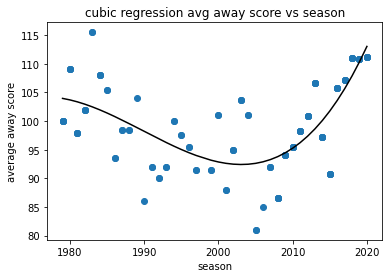

In [65]:
X = table['season'].values.reshape(-1,1)
y = table['avg_away_score'].values.reshape(-1,1)
poly_reg = PolynomialFeatures(degree=3)
X_poly = poly_reg.fit_transform(X)
pol_reg = LinearRegression()
pol_reg.fit(X_poly, y)
plt.scatter(X, y)
plt.plot(X, pol_reg.predict(poly_reg.fit_transform(X)), color='black')
plt.xlabel("season")
plt.ylabel("average away score")
plt.title("cubic regression avg away score vs season")

Great, we can see these results parallel that of the home teams, and perhaps the regression even fits better for the away scores.

## Random Insights picked up from Data Exploration

We plotted earlier average away score vs average home score. Let's plot that again and fit it with a regression:

Text(0.5, 1.0, 'liner regression for average scores on Christmas Day 1979-2020')

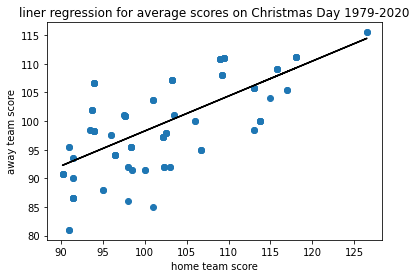

In [66]:
#temporary new table with only prospective X and y for this plot
table2 = table[['avg_home_score', 'avg_away_score']]
X = table2.drop('avg_away_score', axis=1)
y = table2['avg_away_score']

model = linear_model.LinearRegression().fit(X, y)
predictions = model.predict(X)
plt.scatter(table['avg_home_score'], table['avg_away_score'])
plt.plot(table['avg_home_score'], predictions, c='black')
plt.xlabel("home team score")
plt.ylabel("away team score")
plt.title("liner regression for average scores on Christmas Day 1979-2020")

Here we can see that as the average home score increases, so does the average away score. Interesting. This may give some insights as to how teams play off of eachother, or whether their offensive or defensive motivations depend on the other team. Not really relevant to either of out hypotheses but interesting nonetheless

# Part 5: Communication of Insights Attained

## Quick overview of our process

Through this process, we gathered information, trimmed the fat and made it more useable, looked at our data with a microscope and from every angle, made some hypotheses, and finaly tested them with Machine Learning.

## Discoveries

We discovered that home team score and away team score seem to have a linear relationship. As home team score increases, so does away team score. We also discovered that the home team on average outscores the away team, whether they have an outside advantage due to lack of travel or some other reason, we can't know for sure. Finaly, we discovered that the claims of NBA teams scoring more than ever do seem to be built on a kernel of truth. We took quite a journey on that one, going from seemingly proving the hypothesis wrong, to finding a better fit for our data and eventually proving it right with a polynomial regression, proving to us along the way that there are many different ways to view data, and many different insights to be attained from the same set of data.

## Relevant Links

* API we used: https://www.balldontlie.io/#introduction
* More information on APIs: https://www.freecodecamp.org/news/what-is-an-api-in-english-please-b880a3214a82/

* General Machine Learning info: https://towardsdatascience.com/machine-learning-basics-part-1-a36d38c7916
* Machine Learning and Polynomial Regression in Python: https://towardsdatascience.com/machine-learning-polynomial-regression-with-python-5328e4e8a386

* NBA Scoring article: https://www.usatoday.com/story/sports/nba/2018/10/25/nba-scoring-increase-points-up-2018-19-season/1765493002/
* Evolution of the 3-point shot: https://www.thehoopsgeek.com/history-three-pointer/#:~:text=After%20the%20NBA%20moved%20back,to%2014.1%20in%202011%2D12!
